In [1]:
import gym
import gym_snake

import numpy as np
import torch.nn as nn
import torch

from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('snake-v0')
env.unit_gap = 0
env.grid_size = (30, 30)
env.reward_eat = 1
env.reward_win = 10
env.reward_lose = -1

In [3]:
s = env.reset()

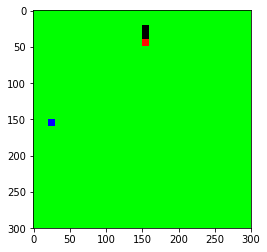

In [4]:
plt.imshow(s)

In [5]:
s, _, _, _ = env.step(1)

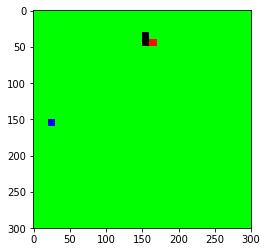

In [6]:
plt.imshow(s)

In [7]:
import cv2

def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (84, 84), interpolation=cv2.INTER_AREA)
    return np.expand_dims(img, 0) # (1, 80, 80)

In [8]:
from collections import deque
import random 

class ReplayMemory(object):
    def __init__(self, capacity):
        self.deque = deque(maxlen=capacity)

    def append(self, state, action, reward, next_state, done):
        self.deque.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.deque, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.deque)

In [ ]:
class FrameHistory(object):
    # consecutive frame을 4개씩 병합하여 새로운 x를 하나씩 만드는 클래스
    # 만들어진 x는 4개씩 concat하고 s를 만들어서 DQN의 input으로 들어감
    def __init__(self, env, k=4):
        self.state_deque = deque(maxlen=k) # [x1, x2, x3, x4]
        self.frame_history_deque = deque(maxlen=k) #[s1, s2, s3, s4]
        self.k = k
        
        # 최초에는 초기 화면(env.reset)으로 채워둠
        self.env = env
        self.initial_state = self.preprocess(self.env.reset())
        self.reset()
        
    def preprocess(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (84, 84), interpolation=cv2.INTER_AREA)
        return np.expand_dims(img, 0) # (1, 80, 80)
    
    def append_frame(self, s):
        # if full, aggregate and clear old frames, append new frame to history queue
        self.frame_history_deque.append(self.preprocess(s))
        
        if len(self) == self.k:
            self.state_deque.append(self.aggregate_frame())
        return
        
    def aggregate_frame(self):
        if len(self) < self.k:
            raise ValueError('not enough frames in history, expected %s, but got %s'%(self.k, len(self)))
        
        # element-wise maximum to aggregate
        frame_history = [self.frame_history_deque.popleft() for _ in range(self.k)]
        return np.maximum.reduce(frame_history[-2:]) #마지막 2 프레임 사용 
    
    def get_state(self):
        S = np.array([self.state_deque[i] for i in range(self.k)]) # S = [x1, x2, x3, x4], (4, 1, 80, 80)
        S = np.swapaxes(S, 0, 1) # (1, 4, 80, 80)
        return S
    
    def reset(self):
        self.frame_history_deque = deque(maxlen=k)
        self.state_deque = deque(maxlen=k)
        
        for _ in range(self.k):
            self.state_deque.append(self.initial_state)
    
    def __len__(self):
        return len(self.frame_history_deque)

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, in_dim, n_action):
        super(ActorCritic, self).__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, 32, (8, 8), stride=4), nn.ReLU(), # conv 1
            nn.Conv2d(32, 64, (4, 4), stride=2), nn.ReLU(), # conv 2
            nn.Conv2d(64, 64, (3, 3), stride=1), nn.ReLU() # conv 3
        )
        
        self.actor_lin = nn.Sequential(
                nn.Linear(64*7*7, 512), nn.ReLU(), # hidden layer
                nn.Linear(512, n_action)
            )
        
        self.critic_lin = nn.Sequential(
                nn.Linear(64*7*7, 512), nn.ReLU(), # hidden layer
                nn.Linear(512, 1)
            )

    def to_tensor(self, img):
        img = torch.tensor(img, dtype=torch.float32, device=self.device).cuda(non_blocking=True) # to tensor
        img /= 255                                   # normalize into 0-1
        while img.dim() < 4 :                        # 4-dim
            img = img.unsqueeze(0)
        return img
        
    def forward(self, frames):
        frames = self.to_tensor(frames) 
        conved = self.conv(frames)
        conved = conved.view(conved.size(0), -1)
        
        action_prob = self.actor_lin(conved)
        action_prob = torch.softmax(action_prob, dim=-1)
        advantage = self.critic_lin(conved).squeeze(1) # dim=1
        return action_prob, advantage

In [ ]:
import torch.nn.init as init

def weight_init(m):
    '''
    Usage:
        model = Model()
        model.apply(weight_init)
    '''
    if isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)

    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)
    return

In [ ]:
#############
k = 1 ## number of skipped frame
#############

actor_critic = ActorCritic(in_dim=k, n_action=4)
actor_critic.to(actor_critic.device) # model to cuda
actor_critic.apply(weight_init)

ActorCritic(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (actor_lin): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
  (critic_lin): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [ ]:
class Fitter():
    def __init__(self, env, actor_critic, k=4):
        self.env = env
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.save_path = ('Snake_actor_critic_state_dict')

        # networks
        self.actor_critic = actor_critic
        self.actor_critic.to(self.actor_critic.device) # model to cuda
        
        # train parameters
        self.gamma = 0.99 #as written in paper
        self.criterion = nn.SmoothL1Loss() # huber loss (error-clipping)
        self.optim = torch.optim.RMSprop(self.actor_critic.parameters(), lr=0.00025, alpha=0.95, eps=0.01) #as written in paper in Rainbow
        self.k = k
        
        # train details
        self.total_frame = 0
        self.total_episode = 0

        self.batch_size = 32
        self.max_replay = 100000
        self.min_replay = 50000
        self.replay_memory = ReplayMemory(self.max_replay)
        self.frame_history = FrameHistory(env=self.env, k=self.k)
        
        self.train_reward_ls = []
        self.test_reward_ls = []
        
        
    def train(self, max_total_frame):
        while self.total_frame < max_total_frame :
            # episode starts!
            self.reset_episode()
            
            done = False
            while not done:
                done = self.run_k_frames()
                
                # training when enough replay-memory, every k-frames
                if len(self.replay_memory) > self.min_replay:
                    self.train_batch(self.batch_size)   
                    self.total_frame += self.k
                
            # single-episode(game) is now done
            # if not enough memory, save more
            if len(self.replay_memory) < self.min_replay:
                print('Not enough replay yet, expected more than %s, but %s instead'%(self.min_replay, len(self.replay_memory)))
                continue
                
            # if enough memory, print train result
            else:
                self.total_episode += 1
                
                if self.total_episode % 100 == 0:
                    print('Train Episode :%s, Total Frame : %s, Train reward : %s,'%(self.total_episode, self.total_frame, self.current_episode_reward))
                    self.train_reward_ls.append(self.current_episode_reward)
            
                # testing, every 1000 episodes when enough replay
                if self.total_episode%1000 == 0:
                    self.test()
                    self.save(self.save_path)
                    
    def reset_episode(self):
        # game(episode) begins
        self.env.reset()  
        self.frame_history.reset() #frame history reset
        self.current_episode_frame = 0         # each episode의 frame 수 
        self.current_episode_reward = 0        # each episode의 reward 합
        
    def choose_action(self, S):
        # at the beginning of an episode, do something
        a_prob, _ = self.actor_critic(S) # pi(a|s)
        a_dist = torch.distributions.Categorical(a_prob) # pi(a|s)
        a = a_dist.sample().item() # a
        return a
    
    def run_k_frames(self):
        # choose action!
        S = self.frame_history.get_state()
        a = self.choose_action(S)
        r_sum = 0
        
        # repeat the action k-times
        for _ in range(self.k):
            s_next, r, done, info = self.env.step(a)
            self.frame_history.append_frame(s_next)
            r_sum += r 
            
            # accumulate history
            self.current_episode_frame += 1
            self.current_episode_reward += r
            
            # if episode(game) ends, return done(True)
            if done: 
                return done
            
        # concat last k-frames into a next state S_next
        S_next = self.frame_history.get_state()
        
        # Terminal when lose life
        self.replay_memory.append(S, a, r_sum, S_next, done) # save replay(experience)
        return done

    def train_batch(self, batch_size):
        # get mini-batch from replay-memory
        S, A, R, S_next, D = self.replay_memory.sample(batch_size)
        A = torch.tensor(A, dtype=torch.long).to(self.device)
        R = torch.tensor(R, dtype=torch.float).to(self.device)
        
        # compute loss and gradient descent
        a_prob, v = actor_critic(S) # pi(a_t|s_t)
        a_dist = torch.distributions.Categorical(a_prob) # pi(a_t|s_t)
        log_a_prob = a_dist.log_prob(A) # A : true actions
        _, v_next = actor_critic(S_next)
        
        TD_error = R + self.gamma*v_next - v
        actor_loss = torch.mean(-log_a_prob*TD_error.data)
        critic_loss = torch.mean(TD_error*TD_error.data)
        loss = actor_loss + critic_loss
        
        # update weights
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
        return
        
    def to_tensor(self, x, dtype=torch.float):
        return torch.tensor(x, dtype=dtype, device=self.device)
    
    def select_indices(self, tensor, indices, dim=1):
        if type(indices) != torch.Tensor:
            indices = self.to_tensor(indices, dtype=torch.long)
        if indices.dim() < 2 :
            indices = indices.unsqueeze(1)
        return tensor.gather(dim, indices).squeeze(1)
    
    def test(self):
        self.reset_episode()
        done=False
        while not done:
            done = self.run_k_frames() # e-greedy
                
        self.test_reward_ls.append(self.current_episode_reward)
        print('※Test※ \t Frames: %s \t Score: %s'%(self.current_episode_frame, self.current_episode_reward))
        return
     
    def save(self, path_to_file):
        torch.save(self.actor_critic.state_dict(), path_to_file)

In [ ]:
fitter = Fitter(env, actor_critic, k=k)
#fitter.replay_memory = replay

In [ ]:
max_frame = 50000000
fitter.train(max_frame)

Train Episode :190300, Total Frame : 5138102, Train reward : -1,
Train Episode :190400, Total Frame : 5140802, Train reward : -1,
Train Episode :190500, Total Frame : 5143502, Train reward : -1,
Train Episode :190600, Total Frame : 5146202, Train reward : -1,
Train Episode :190700, Total Frame : 5148902, Train reward : -1,
Train Episode :190800, Total Frame : 5151602, Train reward : -1,
Train Episode :190900, Total Frame : 5154302, Train reward : -1,
Train Episode :191000, Total Frame : 5157002, Train reward : -1,
※Test※ 	 Frames: 27 	 Score: -1
Train Episode :191100, Total Frame : 5159702, Train reward : -1,
Train Episode :191200, Total Frame : 5162402, Train reward : -1,
Train Episode :191300, Total Frame : 5165102, Train reward : -1,
Train Episode :191400, Total Frame : 5167802, Train reward : -1,
Train Episode :191500, Total Frame : 5170502, Train reward : -1,
Train Episode :191600, Total Frame : 5173202, Train reward : -1,
Train Episode :191700, Total Frame : 5175902, Train reward

Train Episode :202900, Total Frame : 5478302, Train reward : -1,
Train Episode :203000, Total Frame : 5481002, Train reward : -1,
※Test※ 	 Frames: 27 	 Score: -1
Train Episode :203100, Total Frame : 5483702, Train reward : -1,
Train Episode :203200, Total Frame : 5486402, Train reward : -1,
Train Episode :203300, Total Frame : 5489102, Train reward : -1,
Train Episode :203400, Total Frame : 5491802, Train reward : -1,
Train Episode :203500, Total Frame : 5494502, Train reward : -1,
Train Episode :203600, Total Frame : 5497202, Train reward : -1,
Train Episode :203700, Total Frame : 5499902, Train reward : -1,
Train Episode :203800, Total Frame : 5502602, Train reward : -1,
Train Episode :203900, Total Frame : 5505302, Train reward : -1,
Train Episode :204000, Total Frame : 5508002, Train reward : -1,
※Test※ 	 Frames: 27 	 Score: -1
Train Episode :204100, Total Frame : 5510702, Train reward : -1,
Train Episode :204200, Total Frame : 5513402, Train reward : -1,
Train Episode :204300, Tot

Train Episode :215400, Total Frame : 5815802, Train reward : -1,
Train Episode :215500, Total Frame : 5818502, Train reward : -1,
Train Episode :215600, Total Frame : 5821202, Train reward : -1,
Train Episode :215700, Total Frame : 5823902, Train reward : 0,
Train Episode :215800, Total Frame : 5826602, Train reward : 0,
Train Episode :215900, Total Frame : 5829302, Train reward : -1,
Train Episode :216000, Total Frame : 5832002, Train reward : -1,
※Test※ 	 Frames: 27 	 Score: -1
Train Episode :216100, Total Frame : 5834702, Train reward : -1,
Train Episode :216200, Total Frame : 5837402, Train reward : -1,
Train Episode :216300, Total Frame : 5840102, Train reward : -1,
Train Episode :216400, Total Frame : 5842802, Train reward : -1,
Train Episode :216500, Total Frame : 5845502, Train reward : -1,
Train Episode :216600, Total Frame : 5848202, Train reward : -1,
Train Episode :216700, Total Frame : 5850902, Train reward : -1,
Train Episode :216800, Total Frame : 5853602, Train reward :

Train Episode :227500, Total Frame : 6142502, Train reward : -1,
Train Episode :227600, Total Frame : 6145202, Train reward : -1,
Train Episode :227700, Total Frame : 6147902, Train reward : -1,
Train Episode :227800, Total Frame : 6150602, Train reward : -1,
Train Episode :227900, Total Frame : 6153302, Train reward : -1,
Train Episode :228000, Total Frame : 6156002, Train reward : -1,
※Test※ 	 Frames: 27 	 Score: -1
Train Episode :228100, Total Frame : 6158702, Train reward : -1,
Train Episode :228200, Total Frame : 6161402, Train reward : -1,
Train Episode :228300, Total Frame : 6164102, Train reward : -1,
Train Episode :228400, Total Frame : 6166802, Train reward : -1,
Train Episode :228500, Total Frame : 6169502, Train reward : -1,
Train Episode :228600, Total Frame : 6172202, Train reward : -1,
Train Episode :228700, Total Frame : 6174902, Train reward : -1,
Train Episode :228800, Total Frame : 6177602, Train reward : -1,
Train Episode :228900, Total Frame : 6180302, Train reward

Train Episode :239600, Total Frame : 6469202, Train reward : -1,
Train Episode :239700, Total Frame : 6471902, Train reward : -1,
Train Episode :239800, Total Frame : 6474602, Train reward : -1,
Train Episode :239900, Total Frame : 6477302, Train reward : -1,
Train Episode :240000, Total Frame : 6480002, Train reward : -1,
※Test※ 	 Frames: 27 	 Score: -1
Train Episode :240100, Total Frame : 6482702, Train reward : -1,
Train Episode :240200, Total Frame : 6485402, Train reward : -1,
Train Episode :240300, Total Frame : 6488102, Train reward : -1,
Train Episode :240400, Total Frame : 6490802, Train reward : -1,
Train Episode :240500, Total Frame : 6493502, Train reward : -1,
Train Episode :240600, Total Frame : 6496202, Train reward : -1,
Train Episode :240700, Total Frame : 6498902, Train reward : -1,
Train Episode :240800, Total Frame : 6501602, Train reward : -1,
Train Episode :240900, Total Frame : 6504302, Train reward : -1,
Train Episode :241000, Total Frame : 6507002, Train reward

Train Episode :251700, Total Frame : 6795902, Train reward : -1,
Train Episode :251800, Total Frame : 6798602, Train reward : -1,
Train Episode :251900, Total Frame : 6801302, Train reward : -1,
Train Episode :252000, Total Frame : 6804002, Train reward : -1,
※Test※ 	 Frames: 27 	 Score: -1
Train Episode :252100, Total Frame : 6806702, Train reward : -1,
Train Episode :252200, Total Frame : 6809402, Train reward : -1,
Train Episode :252300, Total Frame : 6812102, Train reward : -1,
Train Episode :252400, Total Frame : 6814802, Train reward : -1,
Train Episode :252500, Total Frame : 6817502, Train reward : -1,
Train Episode :252600, Total Frame : 6820202, Train reward : -1,
Train Episode :252700, Total Frame : 6822902, Train reward : -1,
Train Episode :252800, Total Frame : 6825602, Train reward : -1,
Train Episode :252900, Total Frame : 6828302, Train reward : -1,
Train Episode :253000, Total Frame : 6831002, Train reward : -1,
※Test※ 	 Frames: 27 	 Score: -1
Train Episode :253100, Tot

Train Episode :263800, Total Frame : 7122602, Train reward : -1,
Train Episode :263900, Total Frame : 7125302, Train reward : -1,
Train Episode :264000, Total Frame : 7128002, Train reward : -1,
※Test※ 	 Frames: 27 	 Score: -1
Train Episode :264100, Total Frame : 7130702, Train reward : -1,
Train Episode :264200, Total Frame : 7133402, Train reward : -1,
Train Episode :264300, Total Frame : 7136102, Train reward : -1,
Train Episode :264400, Total Frame : 7138802, Train reward : -1,
Train Episode :264500, Total Frame : 7141502, Train reward : -1,
Train Episode :264600, Total Frame : 7144202, Train reward : -1,
Train Episode :264700, Total Frame : 7146902, Train reward : -1,
Train Episode :264800, Total Frame : 7149602, Train reward : -1,
Train Episode :264900, Total Frame : 7152302, Train reward : -1,
Train Episode :265000, Total Frame : 7155002, Train reward : -1,
※Test※ 	 Frames: 27 	 Score: -1
Train Episode :265100, Total Frame : 7157702, Train reward : -1,
Train Episode :265200, Tot

Train Episode :275900, Total Frame : 7449302, Train reward : -1,
Train Episode :276000, Total Frame : 7452002, Train reward : -1,
※Test※ 	 Frames: 27 	 Score: -1
Train Episode :276100, Total Frame : 7454702, Train reward : -1,
Train Episode :276200, Total Frame : 7457402, Train reward : -1,
Train Episode :276300, Total Frame : 7460102, Train reward : -1,
Train Episode :276400, Total Frame : 7462802, Train reward : -1,
Train Episode :276500, Total Frame : 7465502, Train reward : -1,
Train Episode :276600, Total Frame : 7468202, Train reward : -1,
Train Episode :276700, Total Frame : 7470902, Train reward : -1,
Train Episode :276800, Total Frame : 7473602, Train reward : -1,
Train Episode :276900, Total Frame : 7476302, Train reward : -1,
Train Episode :277000, Total Frame : 7479002, Train reward : -1,
※Test※ 	 Frames: 27 	 Score: -1
Train Episode :277100, Total Frame : 7481702, Train reward : -1,
Train Episode :277200, Total Frame : 7484402, Train reward : -1,
Train Episode :277300, Tot

Train Episode :288000, Total Frame : 7776002, Train reward : -1,
※Test※ 	 Frames: 27 	 Score: -1
Train Episode :288100, Total Frame : 7778702, Train reward : -1,
Train Episode :288200, Total Frame : 7781402, Train reward : -1,
Train Episode :288300, Total Frame : 7784102, Train reward : -1,
Train Episode :288400, Total Frame : 7786802, Train reward : -1,
Train Episode :288500, Total Frame : 7789502, Train reward : -1,
Train Episode :288600, Total Frame : 7792202, Train reward : -1,
Train Episode :288700, Total Frame : 7794902, Train reward : -1,
Train Episode :288800, Total Frame : 7797602, Train reward : -1,
Train Episode :288900, Total Frame : 7800302, Train reward : -1,
Train Episode :289000, Total Frame : 7803002, Train reward : -1,
※Test※ 	 Frames: 27 	 Score: -1
Train Episode :289100, Total Frame : 7805702, Train reward : -1,
Train Episode :289200, Total Frame : 7808402, Train reward : -1,
Train Episode :289300, Total Frame : 7811102, Train reward : -1,
Train Episode :289400, Tot

Train Episode :300100, Total Frame : 8102702, Train reward : -1,
Train Episode :300200, Total Frame : 8105402, Train reward : -1,
Train Episode :300300, Total Frame : 8108102, Train reward : -1,
Train Episode :300400, Total Frame : 8110802, Train reward : -1,
Train Episode :300500, Total Frame : 8113502, Train reward : -1,
Train Episode :300600, Total Frame : 8116202, Train reward : -1,
Train Episode :300700, Total Frame : 8118902, Train reward : -1,
Train Episode :300800, Total Frame : 8121602, Train reward : -1,
Train Episode :300900, Total Frame : 8124302, Train reward : -1,
Train Episode :301000, Total Frame : 8127002, Train reward : -1,
※Test※ 	 Frames: 27 	 Score: 0
Train Episode :301100, Total Frame : 8129702, Train reward : -1,
Train Episode :301200, Total Frame : 8132402, Train reward : 0,
Train Episode :301300, Total Frame : 8135102, Train reward : -1,
Train Episode :301400, Total Frame : 8137802, Train reward : -1,
Train Episode :301500, Total Frame : 8140502, Train reward :